In [15]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import librosa
import librosa.display
import pandas as pd
import numpy as np
import base64
import imageio as iio
from plotting import Plotting
import plotly.graph_objects as go

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example working with an audio file

In [2]:
test_aud_file = "audio_demo/junction_test_bike.wav"

aud, SR = librosa.load(test_aud_file, sr=22050)

Text(0.5, 1.0, 'Recorded waveform')

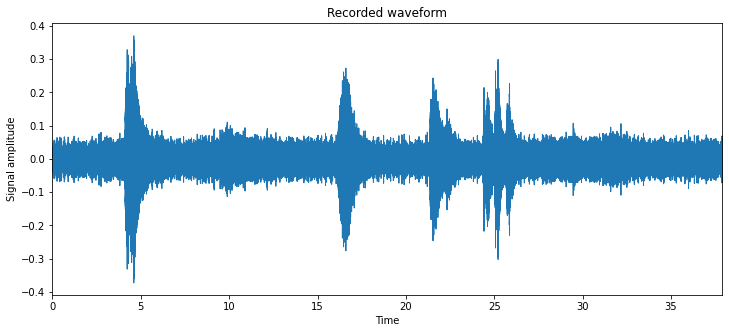

In [3]:
# %% Plot signal waves 
plt.figure(figsize=(12,5))
librosa.display.waveplot(aud, sr=SR)
plt.ylabel("Signal amplitude")
plt.title("Recorded waveform")



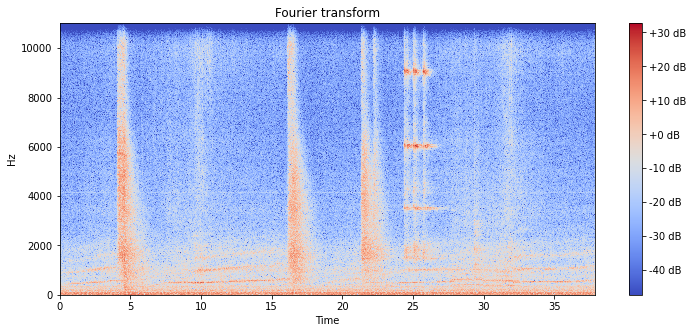

In [6]:
# STFT short time fourier transform

X = librosa.stft(aud)
X_db = librosa.amplitude_to_db(np.abs(X))


fig, ax = plt.subplots(figsize = (12, 5))
img = librosa.display.specshow(X_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Fourier transform')
fig.colorbar(img, ax=ax, format="%+2.f dB")


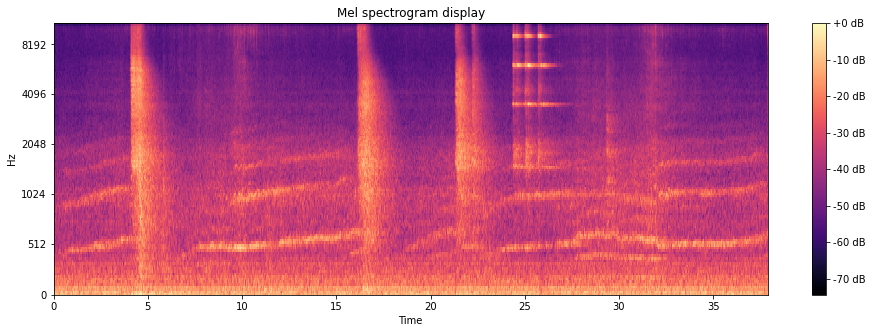

In [7]:
# Mel spectogram

fig, ax = plt.subplots(figsize = (16, 5))
M = librosa.feature.melspectrogram(y=aud, sr=SR)
M_db = librosa.power_to_db(M, ref=np.max)
img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
ax.set(title='Mel spectrogram display')
fig.colorbar(img, ax=ax, format="%+2.f dB")


## Load site_6 (garage) sensor data

<ol>
<li>First load the pickle file and convert the timestamps to Helsinki timezone</li>
<li>Next load the json file containing deviceids</li>
<li>Finally load the png file as both a numpy array and a base64 encoded image. We need the later for plotting in Plotly helper functions</li>
</ol>

In [4]:
df_events = pd.read_pickle(f'./audio_data/site_6.pkl', compression='gzip')

In [5]:
df_events.loc[:, 'timestamp'] = (pd.to_datetime(df_events['timestamp'], utc=True)
                                 .dt.tz_convert('Europe/Helsinki')
                                 .dt.tz_localize(None))

In [6]:
df_events.head(5)

,timestamp,deviceid
0,2021-10-28 18:25:03.738,5
1,2021-10-28 18:25:03.989,5
2,2021-10-28 18:25:04.144,74
3,2021-10-28 18:25:04.261,34
4,2021-10-28 18:25:04.425,34


In [8]:
df_devices = pd.read_json(f'./audio_data/site_6.json')

In [23]:
df_devices.tail(5)

,deviceid,x,y
151,151,1012.132805,532.820374
152,audio_sensor_4,903.212359,1065.803693
153,audio_sensor_2,1325.483386,672.277047
154,audio_sensor_1,895.412256,677.966359
155,audio_sensor_3,1334.579512,1059.567587


In [10]:
with open(f'./audio_data/site_6.png', "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode()

In [12]:
img = iio.imread(f'./audio_data/site_6.png')
img.shape

(1317, 2635, 4)

We can now load the floorplan just to get a feel of what the devices look like.

In [20]:
scaling_factor = 2 # Set to 1 for highest resolution
plotting_obj = Plotting(bg_img=encoded_string, dims=(img.shape[1], img.shape[0]), df_devices=df_devices, scaling_factor=scaling_factor)
plotting_obj.run(renderer='browser') # Switch to iframe if you would like to view it here

## Challenge Category 1
<p>For the first challenge, we want to solve a real-world problem of indoor device mapping. The floorplans we have provided you with already contain mapped devices, meaning they have defined locations on a floorplan. In reality, this takes a lot of time. We physically need to identify each device inside the building and place them on a floorplan. The objective of this exercise is to come up with ways to speed up this process. We have written down some ideas below, however feel free to be creative! You can come up with entirely new ideas of your own.</p>

#### Example Aproach:
<p>Let's assume the floorplan contains 500 devices. We can delete 400 devices, and use the occupancy events data to identify neighbours. Once the neighbours have been identified, we can simply use the data to locate the missing 400 devices! This means our engineers only need to locate 100 devices, and let the system run for N days and then find the rest.</p> 
<p>The Machine Learning aspect of the challenge comes from: 1. increasing the number of deleted devices, and 2. the smallest possible value of N that gives the best mappings. You can use Euclidean distance between the predicted location of the object and the actual location from our provided floorplans to determine accuracy of your algorithm. We have provided 5 different sites with a variety of device configurations and data, so be sure to properly create Training and Test Datasets!</p>

#### Ideas:
* Build a graph with most correlated sensors

## Challenge Category 2
<p>The second challenge is more about providing value to the client. We have provided data from real-world buildings. These buildings are occupied according to certain predictable patterns. For example a school might only observe occupancy during the morning. A hospital or a shopping mall might observe occupancy throughout the day. The objective of this exercise is to determine how people move through buildings by combining spatial and temporal data. </p>

#### Example Aproach:
<p>We can define a graph network of devices, with the edge weights representing the distance between devices. Then depending on the proximity of devices and the correlation of events within a certain time-window, say 15 minutes, we can cluster the most frequently visited spaces in a building. By creating similar sequences across the day, week or month we can determine patterns that show us how the building is used at different times of the day, or different days of the week etc. We can also try to figure out which paths are dominant and which are used least frequently. Such information is extremely valuable to building owners and tenants.</p> 
<p>You can experiment with different windowing approaches. Try to think about what sort of metrics are important. Is it really worth investigaing how the occupancy changes at midnight, or is it worth understanding how people move through the building at 9AM? Also, does the pattern change during the week, for example do more people visit on Monday or Friday?</p>
<p>We would love to see your ideas on what is the best way to present the results of this type of data analysis to the customers. UI/UX experts, we're looking at you!</p>

#### Ideas:
* where to place ads
* where to place coffee machines
* flow of people
* evacuation plans 
* elevators

## Challenge Category 3
<p>The last challenge is related to a type of sensor that is not common in smart buildings at the moment: audio sensors. We have availabe motion sensors that generate occupancy data, but we decided to augmnet that with audio data. We want to explore the utility of incorporating more data sources in a smart building.</p>
<p>The data collection is done at a garage, and contains 4 audio sensors placed in a rectangular grid. There is a lot of activity happening in the garage: people are walking, driving their car, or bicycles. The objective would be to identify these events by combining the audio streams from all the 4 sensors and by incorporating motion data to pinpoint where the activity was taking place.</p>

#### Example Aproach:
<p>This is an extremely open ended challenge. There are numerous ways this can be tackled. Clever audio signal processing, or using deep learning to detect events. The choice is yours.</p> 

#### Ideas:
* identify events
